(causal-inference-notebook)=
# Inferenza causale

Lo scopo di questo capitolo è di introdurre il modello di regressione multipla e di discutere come esso si collega all'analisi causale. 

## Preparazione del Notebook

In [1]:
import warnings

import arviz as az
import bambi as bmb
import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "regr_causal_inference"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

Il modello di regressione multipla è un concetto fondamentale nell'ambito della statistica e dell'analisi dei dati. Si tratta di un'estensione del modello di regressione bivariato che permette di includere più predittori nel modello. Questo significa che, invece di considerare solo una variabile indipendente per predire una variabile dipendente, ora abbiamo più predittori.

Nel modello di regressione multipla, la variabile dipendente, che chiameremo $Y$, viene predetta prendendo in considerazione la presenza di molteplici variabili indipendenti, che chiameremo $X_1, X_2, \ldots, X_p$. Il modello assume che il valore atteso di $Y$ condizionato alle variabili indipendenti può essere descritto da un'equazione lineare:

$$E(Y) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \ldots + \beta_pX_p.$$

In questa equazione, i coefficienti $\beta_0, \beta_1, \beta_2, \ldots, \beta_p$ rappresentano i coefficienti parziali di regressione. Ogni $\beta_i$ riflette la relazione tra la variabile dipendente $Y$ e la variabile indipendente corrispondente $X_i$, considerando anche l'effetto delle altre variabili presenti nel modello.

Una differenza chiave rispetto al modello di regressione bivariato è nell'interpretazione dei coefficienti. Nel caso bivariato, il coefficiente $\beta_1$ viene interpretato come il cambiamento atteso in $Y$ al variare di una unità in $X_1$. Tuttavia, nel modello di regressione multipla, l'interpretazione di $\beta_1$ cambia. In questo caso, $\beta_1$ rappresenta il cambiamento atteso in $Y$ al variare di una unità in $X_1$, mantenendo costanti gli effetti di tutte le altre variabili $X_2, X_3, \ldots, X_p$. In altre parole, $\beta_1$ ci dice come varia in media $Y$ quando $X_1$ cambia, ma considera che altre variabili possono variare insieme a $X_1$, e $\beta_1$ tiene conto di queste variazioni.

Cosa significa mantenere costante l'effetto di altre variabili? Consideriamo l'esempio della correlazione tra il numero di scarpe e le abilità matematiche. Esiste una marcata correlazione positiva tra queste due variabili. Tuttavia, è evidente che i bambini, avendo in genere numeri di scarpe più piccoli rispetto agli adulti, mostrano anche, presumibilmente, minori capacità matematiche. Questo esempio illustra che, se controlliamo per l'età, ossia se consideriamo solo soggetti della stessa età, la correlazione tra il numero di scarpe e le abilità matematiche scompare. Pertanto, nell'analisi della relazione tra abilità matematiche (Y) e numero di scarpe (X), l'età (Z) agisce come variabile confondente. Controllare per Z significa esaminare la relazione tra Y e X limitandosi a individui della stessa età.

Ma ovviamente questo controllo empirico non è sempre possibile. Nel modello di regressione, esso viene "approssimato" con una procedura statistica. 

**Esempio.** In questo esempio illustreremo la procedura statistica utilizzata per isolare l'effetto di una variabile controllando per un'altra. 

In [3]:
# Creiamo dei dati di esempio
np.random.seed(0)
N = 100
X1 = np.random.normal(0, 1, N)
X2 = X1 + np.random.normal(0, 0.5, N)
Y = 1 + 2 * X1 + 3 * X2 + np.random.normal(0, 1, N)

# Modello completo Y ~ X1 + X2
model_full = sm.OLS(Y, sm.add_constant(np.column_stack((X1, X2))))
results_full = model_full.fit()

# Regressione di Y su X2
model_Y_on_X2 = sm.OLS(Y, sm.add_constant(X2))
residuals_Y = model_Y_on_X2.fit().resid

# Regressione di X1 su X2
model_X1_on_X2 = sm.OLS(X1, sm.add_constant(X2))
residuals_X1 = model_X1_on_X2.fit().resid

# Regressione dei residui di Y sui residui di X1
model_residuals = sm.OLS(residuals_Y, sm.add_constant(residuals_X1))
results_residuals = model_residuals.fit()

# Stampiamo i risultati
print("Coefficient from full model for X1: {:.4f}".format(results_full.params[1]))
print(
    "Coefficient from regression of residuals: {:.4f}".format(
        results_residuals.params[1]
    )
)

Coefficient from full model for X1: 1.9782
Coefficient from regression of residuals: 1.9782


Il concetto di *coefficiente parziale di regressione* viene illustrato in questo esempio. Questo coefficiente quantifica l'effetto della variabile esplicativa $X_j$ sulla variabile dipendente $Y$, depurando l'effetto di $X_j$ dall'influenza degli altri predittori nel modello. In sostanza, il coefficiente parziale di regressione valuta l'impiego di $X_j$ su $Y$ quando $X_j$ è considerata *linearmente indipendente* rispetto agli altri predittori $X$. L'effetto misurato è quindi quello della sola componente di $X_j$ che non è spiegata linearmente dai restanti predittori $X$ sulla parte di $Y$ che è anch'essa indipendente dai medesimi predittori.

Per chiarire ulteriormente, questo approccio statistico si focalizza sull'analizzare l'effetto di $X_j$ eliminando l'influenza lineare degli altri predittori $X$. È simile a valutare la relazione tra $Y$ e $X_j$ in un contesto ideale dove tutti gli individui presentano livelli identici per le altre variabili $X$. Tale metodo non eguaglia gli effetti non lineari che possono essere presenti tra le variabili, limitandosi a correggere solo per le associazioni lineari. In questo modo, il controllo statistico tenta di approssimare una condizione di omogeneità tra i soggetti rispetto alle altre variabili $X$, consentendo di isolare e valutare più precisamente l'effetto puro di $X_j$ su $Y$.

### Scopi della regressione

L'utilizzo del modello di regressione multipla ha principalmente due scopi. In primo luogo, è utilizzato per la predizione, cioè per ottenere la migliore stima possibile di $Y$ utilizzando una combinazione lineare delle variabili $X_1, X_2, \ldots, X_p$. In questo contesto, i coefficienti $\beta_i$ sono considerati come pesi che permettono di effettuare questa previsione.

In secondo luogo, il modello di regressione multipla viene spesso utilizzato per descrivere le relazioni causali tra le variabili. Tuttavia, è importante sottolineare che questo modello non è stato originariamente creato per stabilire relazioni causali, ed è necessario essere cauti nell'attribuire interpretazioni causali dirette ai coefficienti $\beta_i$. Questo perché il modello stima correttamente i coefficienti parziali di regressione solo quando tutte le variabili che influenzano $Y$ sono incluse nel modello. Nella pratica, spesso non conosciamo tutte le variabili causalmente rilevanti, il che può portare a problemi di errore di specificazione.

In conclusione, il modello di regressione multipla rappresenta uno strumento potente per predire e analizzare le relazioni tra variabili. Tuttavia, è fondamentale riconoscerne le limitazioni, specialmente quando si tentano interpretazioni causali. In ambiti come la psicologia, dove è cruciale comprendere le dinamiche causali, diventa essenziale una scelta accurata delle variabili da includere nel modello per prevenire distorsioni nelle stime dei coefficienti di regressione.

Tradizionalmente, si riteneva vantaggioso includere nel modello il maggior numero possibile di variabili per ottenere un livello di "controllo" statistico più elevato. Tuttavia, come sottolineato da {cite:t}`McElreath_rethinking`, questo metodo può trasformarsi in una "insalata causale". Questo termine descrive una situazione in cui la mancanza di attenzione alla struttura causale tra le variabili può portare all'inclusione di variabili di controllo inappropriate, causando distorsioni nelle stime.

In alcuni casi, l'inserimento di determinate variabili di controllo nel modello è indispensabile per evitare distorsioni, mentre in altri casi, l'inclusione di variabili non pertinenti può portare a risultati fuorvianti. Questo enfatizza l'importanza di formulare ipotesi chiare e ben ponderate sulla struttura causale che intercorre tra le variabili in esame.

L'efficacia e la validità dei risultati ottenuti tramite regressione dipendono strettamente dalla correttezza delle ipotesi causali formulate, sia esplicitamente che implicitamente, dal ricercatore. Pertanto, per superare i limiti dell'approccio dell'"insalata causale", è cruciale che la formulazione del modello di regressione rifletta attentamente tali ipotesi causali.

## Modello di Regressione e Analisi Causale

Nel prosieguo di questo capitolo, approfondiremo l'analisi del modello di regressione e l'analisi causale per esaminare come l'inclusione di covariate in un modello multivariato possa influenzare la nostra interpretazione degli effetti causali. Un aspetto cruciale che esploreremo è se l'aggiustamento per una covariata, che indicheremo con $C$, possa effettivamente rivelare l'effetto causale di $X$ su $Y$.

Per approfondire questo concetto, analizzeremo come la variabile dipendente $Y$ risponde a variazioni della variabile indipendente $X$, tenendo conto della struttura causale assunta nella generazione dei dati. La discussione si basa su un articolo di {cite:t}`lubke2020we`.

In questo capitolo, distingueremo due tipi di strutture causali. La prima è una struttura a catena, descritta come $X \rightarrow C \rightarrow Y$, dove $X$ influisce su $C$ che, a sua volta, influisce su $Y$. In questo scenario, sarebbe inappropriato condizionare su $C$, poiché $C$ agisce da mediatore nell'effetto di $X$ su $Y$ e condizionare su $C$ eliminerebbe una parte dell'effetto causale che vogliamo misurare.

Il secondo scenario presenta una struttura a forcella: $X \leftarrow C \rightarrow Y$. Qui, $C$ è la causa comune di $X$ e $Y$. In questo contesto, è fondamentale aggiustare per $C$ per eliminare l'effetto confondente e isolare l'effetto diretto di $X$ su $Y$.

Il principio guida di questa analisi è di bloccare i percorsi non causali attraverso la distribuzione condizionata e di aprire i percorsi causali mediante la distribuzione marginale. Questo ci orienta nella scelta delle covariate da includere o escludere dal modello di regressione per ottenere stime più precise dell'effetto causale.

Per illustrare meglio questi concetti, ricorreremo a esempi simulati che dimostrano chiaramente quando è necessario l'aggiustamento per certe covariate per scoprire l'effetto causale reale e quando questo potrebbe introdurre distorsioni nella nostra comprensione della relazione causale. Questa tematica è di particolare importanza nel campo della psicologia, dove comprendere le relazioni causali tra variabili è essenziale per lo sviluppo di teorie robuste e la realizzazione di ricerche empiriche affidabili. 

### Esempio 1: Catena

Un esempio discusso da {cite:t}`lubke2020we` riguarda le seguenti variabilili: apprendimento, conoscenza e comprensione. Possiamo ipotizzare una struttura causale nella quale l'apprendimento ($X$) ha un effetto causale sull'acquisizione di conoscenza ($C$). Successivamente, la conoscenza a sua volta incide sulla comprensione ($Y$). È importante notare che la comprensione ("understanding") è influenzata anche da fattori esterni ($U$), che in modelli di regressione vengono rappresentati tramite il termine di errore.

In situazioni reali, per misurare apprendimento, conoscenza e comprensione, è possibile utilizzare strumenti come questionari o misurazioni specifiche. Questi strumenti consentono di quantificare tali variabili per poterle poi analizzarle in contesti di ricerca.

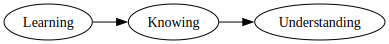

In [4]:
f = graphviz.Digraph()

# Definizione dei nodi e degli archi
f.edge("Learning", "Knowing")
f.edge("Knowing", "Understanding")

# Impostazione dell'orientamento orizzontale
f.attr(rankdir='LR')
f

Per applicare praticamente i concetti discussi, simuliamo i dati seguendo la struttura causale precedentemente descritta:

$$
X = UX, \quad UX \sim \mathcal{N}(0,1)
$$

$$
C = 5 \cdot X + UC, \quad UC \sim \mathcal{N}(0,1)
$$

$$
Y = 3 \cdot C + UY, \quad UY \sim \mathcal{N}(0,1)
$$

Qui, $\mathcal{N}(\mu, \sigma)$ rappresenta la distribuzione normale. 

In [5]:
n = 1000  # sample size

# Simulating the variables
X = np.random.normal(0, 1, n)  # Learning
C = 5 * X + np.random.normal(0, 1, n)  # Knowing
Y = 3 * C + np.random.normal(0, 1, n)  # Understanding

df = pd.DataFrame()
df["X"] = X
df["C"] = C
df["Y"] = Y

df.head()

,X,C,Y
0,-1.306527,-7.979055,-24.205176
1,1.658131,7.838303,23.018301
2,-0.118164,-0.271388,0.522221
3,-0.680178,-3.538670,-10.736052
4,0.666383,2.374768,7.585773


Analizziamo un modello di regressione che considera solo le variabili $X$ ("learning") e $Y$ ("understanding"). Se non includiamo $C$ ("knowing") come covariata nel modello di regressione, otteniamo una stima dell'effetto di "learning" su "understanding" che è priva di distorsioni sistematiche. 

In [6]:
mod1 = bmb.Model("Y ~ X", df)
results1 = mod1.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
az.summary(results1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.12,0.10,-0.30,0.07,0.0,0.0,3778.28,3016.05,1.0
X,14.86,0.10,14.67,15.04,0.0,0.0,3998.45,2848.86,1.0
Y_sigma,3.09,0.07,2.97,3.22,0.0,0.0,4125.58,3093.65,1.0


Secondo il meccanismo di generazione dei dati che abbiamo utilizzato, la stima corretta dell'effetto causale dovrebbe essere $5 \times 3 = 15$, che corrisponde al prodotto dei coefficienti lungo il percorso che collega $X$ a $Y$. Il valore ottenuto dal coefficiente parziale di regressione fornisce una stima statistica corretta di questo valore teorico.

Proseguiamo l'analisi eseguendo una regressione che include anche la variabile $C$ ("knowing"), la quale agisce da mediatore tra "learning" ($X$) e "understanding" ($Y$) nel modello generativo dei dati. La decisione di includere $C$ come covariata può derivare dalla convinzione che l'inserimento di un maggior numero di variabili nel modello di regressione possa potenziare il controllo statistico sulla stima degli effetti.

Esaminiamo ora l'efficacia di questo approccio, che è stato definito "dell'insalata causale" da {cite:t}`McElreath_rethinking`, nel contesto attuale. Questa analisi ci permetterà di valutare se l'aggiunta di $C$ nel modello migliora o compromette la nostra capacità di discernere correttamente l'effetto di "learning" su "understanding".

In [8]:
mod2 = bmb.Model("Y ~ X + C", df)

In [9]:
results2 = mod2.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
az.summary(results2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
C,3.01,0.03,2.94,3.07,0.0,0.0,1839.52,1886.08,1.0
Intercept,-0.05,0.03,-0.11,0.00,0.0,0.0,2624.18,2153.06,1.0
X,-0.09,0.16,-0.42,0.20,0.0,0.0,1869.44,1764.58,1.0
Y_sigma,0.97,0.02,0.93,1.01,0.0,0.0,2684.22,2301.07,1.0


Se includiamo "knowing" come covariata nel modello di regressione, otteniamo una stima distorta dell'effetto di "learning" su "understanding". Questo accade perché, controllando per "knowing", che funge da mediatore, induciamo un bias che riduce artificialmente l'effetto totale di "learning" su "understanding". In conclusione, il condizionamento su un mediatore comporta una distorsione sistematica nei risultati.

### Esempio 2: Biforcazione

In un secondo scenario, analizziamo il ruolo di tre variabili simulate: intelligenza, tempo di apprendimento e punteggio del test. Il modello causale che guida la generazione dei dati assume che l'intelligenza ($C$) eserciti un'influenza positiva sul tempo di apprendimento ($X$). Allo stesso tempo, sia l'intelligenza ($C$) che il tempo di apprendimento ($X$), insieme a fattori esterni non specificati ($U$), influenzano il punteggio al test ($Y$). Per semplificare l'analisi, non consideriamo altre covariate potenzialmente rilevanti come la motivazione o l'interesse degli studenti, focalizzandoci esclusivamente sul tempo dedicato allo studio ($X$).

Le relazioni tra le variabili sono definite dalle seguenti equazioni, dove $\mathcal{N}(\mu, \sigma)$ rappresenta la distribuzione normale:

- L'intelligenza ($C$) è modellata come:
  $$
  C = UC, \quad UC \sim \mathcal{N}(100, 15)
  $$
  
- Il tempo di apprendimento ($X$), influenzato dall'intelligenza, segue l'equazione:
  $$
  X = 200 - C + UX, \quad UX \sim \mathcal{N}(0, 1)
  $$

- Il punteggio del test ($Y$), risultante da intelligenza e tempo di apprendimento, è descritto da:
  $$
  Y = 0.5 \cdot C + 0.1 \cdot X + UY, \quad UY \sim \mathcal{N}(0, 1)
  $$

Queste equazioni riflettono una struttura causale dove l'intelligenza agisce come causa comune sia per il tempo di apprendimento che per il punteggio del test, illustrando un tipico caso di struttura a forcella nel contesto di un modello causale.

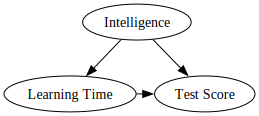

In [11]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("Learning Time")
    s.node("Test Score")

f.node("Intelligence")
f.edge("Intelligence", "Learning Time")
f.edge("Intelligence", "Test Score")
f.edge("Learning Time", "Test Score")

f

In [12]:
n = 1000  # sample size

# Simulating the variables
I = np.random.normal(100, 15, n)  # Intelligence
T = 200 - I + np.random.normal(0, 1, n)  # Learning Time
S = 0.5 * I + 0.1 * T + np.random.normal(0, 1, n)  # Test Score

df = pd.DataFrame()
df["I"] = I
df["T"] = T
df["S"] = S

df.head()

,I,T,S
0,72.214860,127.980207,49.684998
1,89.300095,111.060907,55.562599
2,73.566567,126.585409,49.989393
3,112.457761,87.319967,65.237689
4,111.717509,89.587264,63.532910


I dati analizzati sono stati generati seguendo un modello causale in cui il punteggio al test, $S$, aumenta di 0.1 punti per ogni unità di incremento nel tempo di apprendimento, $T$. Questo implica che più tempo viene dedicato all'apprendimento, più alto è il punteggio medio ottenuto nel test. Consideriamo ora le conseguenze che derivano dall'escludere l'intelligenza, che influisce sia sul tempo di apprendimento che sul punteggio del test, come predittore nel nostro modello di regressione.

In [13]:
mod3 = bmb.Model("S ~ T", df)
results3 = mod3.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
az.summary(results3, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99.8,0.23,99.36,100.21,0.0,0.0,4885.87,3127.08,1.0
S_sigma,1.1,0.02,1.05,1.14,0.0,0.0,2826.40,2649.64,1.0
T,-0.4,0.00,-0.40,-0.39,0.0,0.0,4961.65,3134.46,1.0


I risultati dell'analisi mostrano che, omettendo l'intelligenza dal modello utilizzato per valutare il punteggio del test, si verifica un errore di stima tale da invertire addirittura la direzione dell'effetto reale di $X$ (Tempo di Apprendimento) su $Y$ (Punteggio del Test). Questo errore è un esempio del "paradosso di Simpson" {cite:p}`simpson1951interpretation`, fenomeno per cui le relazioni apparenti tra variabili possono capovolgersi o alterarsi significativamente quando non si considera una variabile confondente critica, nel nostro caso l'intelligenza.

Se condizioniamo sull'intelligenza, invece, l'effetto di "Learning Time" su "Test Score" viene stimato senza errori sistematici.

In [15]:
mod4 = bmb.Model("S ~ T + I", df)
results4 = mod4.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
az.summary(results4, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I,0.47,0.03,0.41,0.53,0.00,0.00,1316.10,1550.07,1.0
Intercept,5.88,6.08,-5.01,18.09,0.17,0.12,1315.68,1524.18,1.0
S_sigma,0.99,0.02,0.95,1.03,0.00,0.00,2352.48,1915.88,1.0
T,0.07,0.03,0.01,0.13,0.00,0.00,1318.89,1560.52,1.0


Questo esempio sottolinea l'importanza di comprendere accuratamente la struttura causale che sta alla base della generazione dei dati. Senza questa comprensione, diventa difficile determinare se l'effetto di $X$ su $Y$ sia positivo o negativo. Per ottenere stime affidabili delle relazioni causali tra le variabili, è fondamentale integrare la struttura causale del processo di generazione dei dati all'interno del modello di regressione. Questo approccio è essenziale per evitare conclusioni errate e garantire l'accuratezza delle inferenze causali.

## Riflessioni sulle Simulazioni di {cite:t}`lubke2020we`

Le simulazioni discusse nell'articolo di {cite:t}`lubke2020we` mettono in luce questioni metodologiche di rilievo e sollevano critiche fondamentali sull'uso convenzionale dei modelli di regressione. La pratica diffusa di incorporare un elevato numero di variabili nei modelli di regressione senza una selezione rigorosa si è rivelata non solo inappropriata ma anche potenzialmente fuorviante. Questo metodo, spesso adottato nella speranza di perfezionare il modello, ignora l'importanza critica di esaminare le relazioni causali tra le variabili.

In particolare, le simulazioni di {cite:t}`lubke2020we` dimostrano come l'inserimento indiscriminato di covariate possa creare associazioni spurie, compromettendo la validità dei risultati ottenuti. Per sviluppare un modello di regressione che non solo si adatti efficacemente ai dati disponibili ma che anche rappresenti accuratamente la struttura causale sottostante, è essenziale una selezione attenta delle covariate. Questa selezione deve essere informata da una comprensione del processo generativo dei dati. La decisione su quali variabili includere in un modello di regressione, dunque, non deve basarsi esclusivamente su criteri statistici, ma deve essere invece guidata da solide basi teoriche.

## L'Inferenza Causale Va Oltre la Statistica

Le simulazioni presentate da {cite:t}`lubke2020we` dimostrano che l'identificazione delle relazioni causali che regolano i fenomeni non può avvenire attraverso l'uso esclusivo di strumenti statistici, senza una solida conoscenza del contesto specifico. Questa tesi è ulteriormente sottolineata nell'articolo di {cite:t}`d2024causal`, intitolato "Causal Inference Is Not Just a Statistics Problem". Per approfondire questa idea, gli autori introducono un "causal quartet", ispirato al celebre quartetto di Anscombe. Il Quartetto di Anscombe è formato da quattro set di dati che, nonostante abbiano identiche proprietà statistiche quali media, varianza e correlazione, si distinguono nettamente nella rappresentazione grafica. Questo esempio è spesso utilizzato per evidenziare l'importanza dell'analisi visiva dei dati, al pari dell'analisi statistica, nell'interpretazione corretta delle informazioni. Allo stesso modo, il "causal quartet" illustra come l'integrazione tra comprensione causale e analisi statistica sia essenziale per effettuare inferenze valide.

Iniziamo ad esaminare il dataset di Anscombe.

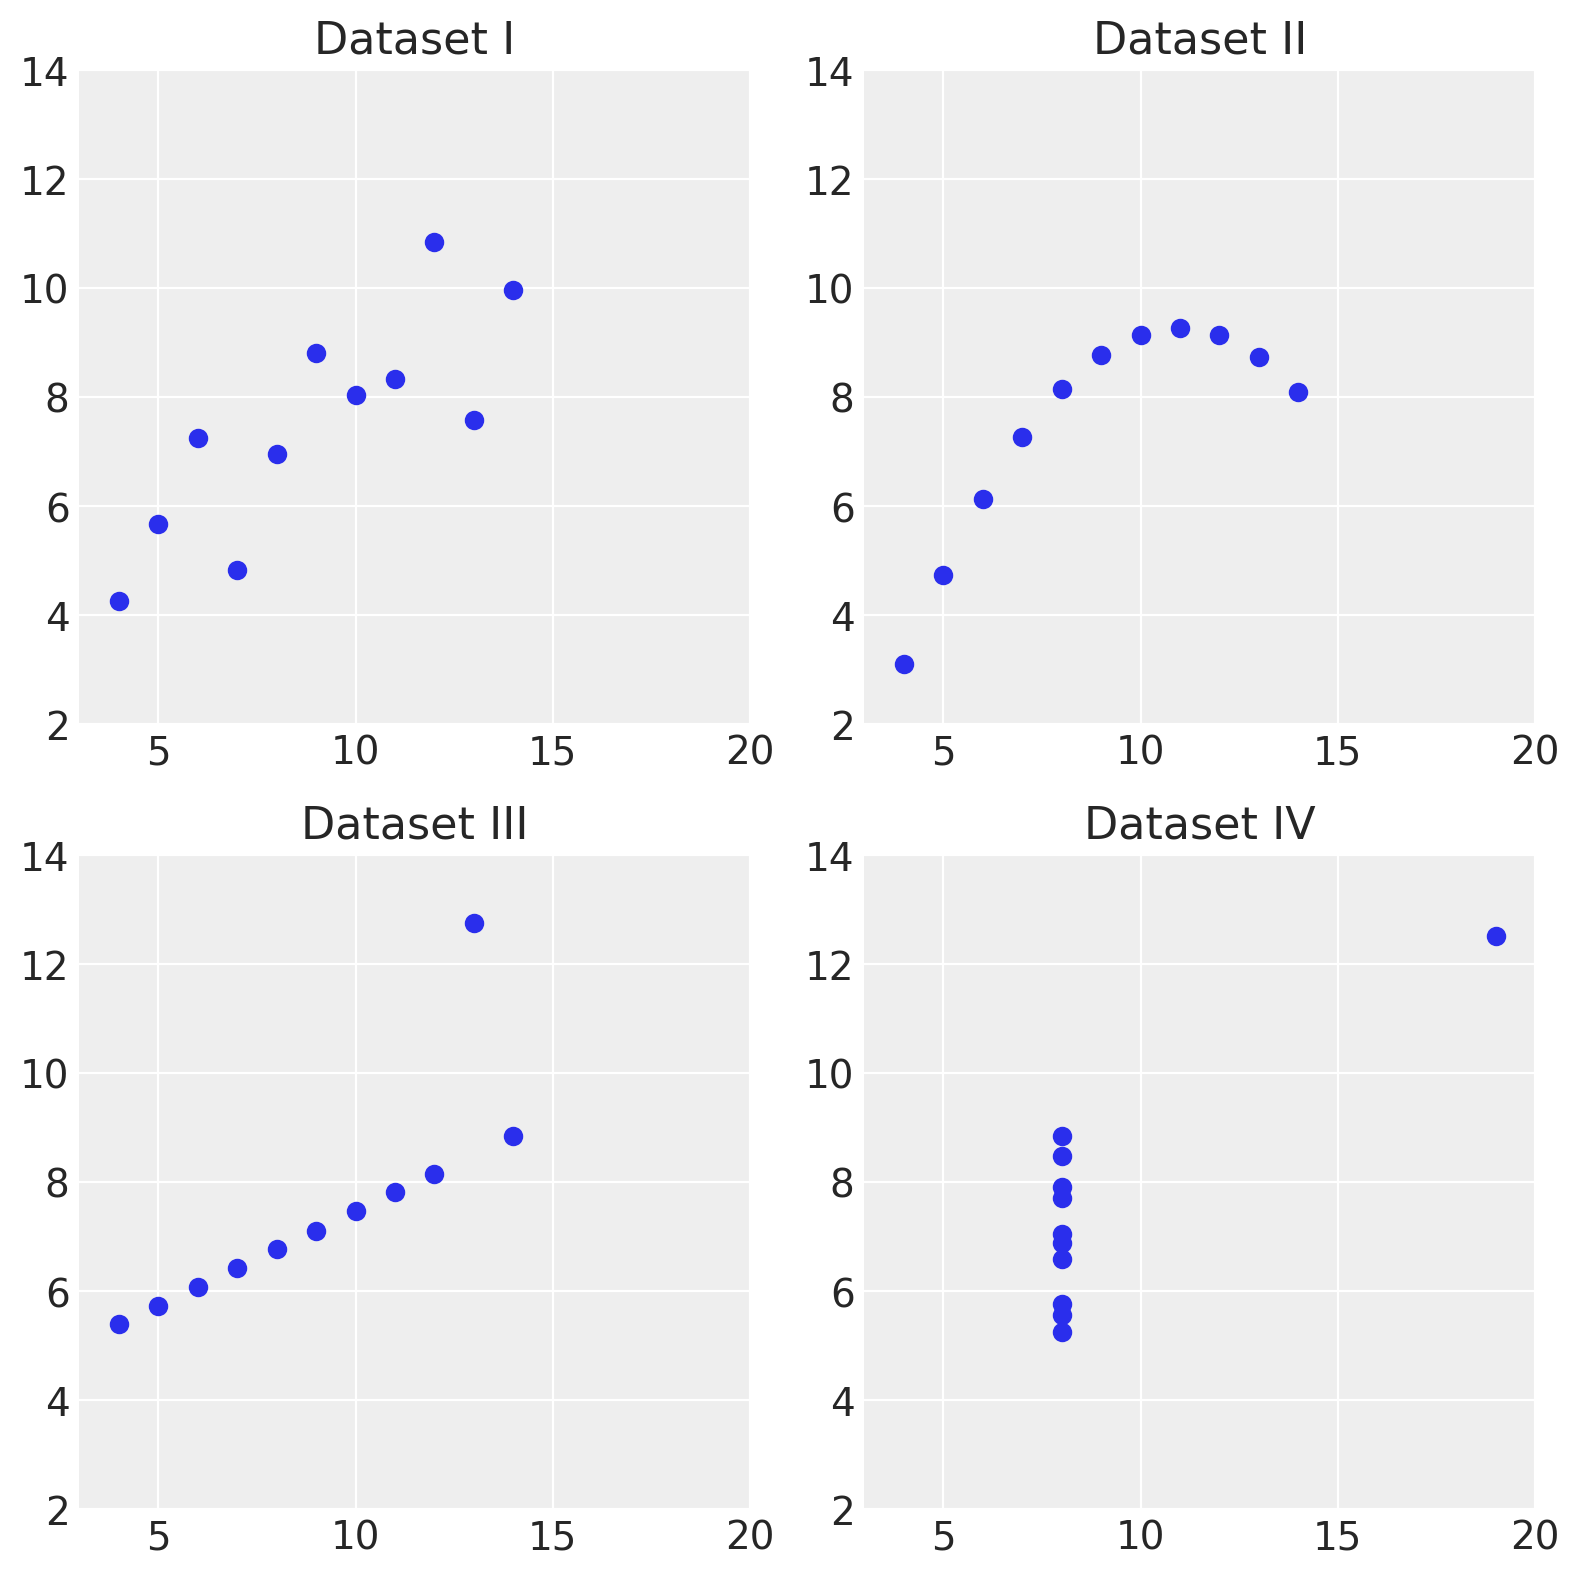

In [17]:
df = sns.load_dataset("anscombe")

# Creare una figura e un array di assi
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Disegnare ogni gruppo in un subplot diverso
for i, dataset in enumerate(df['dataset'].unique()):
    ax = axs[i // 2, i % 2]
    data = df[df['dataset'] == dataset]
    ax.scatter(data['x'], data['y'])
    ax.set_title(f'Dataset {dataset}')
    ax.set_xlim([3, 20])
    ax.set_ylim([2, 14])

# Aggiustare lo spazio tra i grafici
plt.tight_layout()

# Mostrare la figura
plt.show()


I quattro dataset di Anscombe sono notevoli perché sono stati progettati per avere la stessa media e varianza nelle variabili $X$ e $Y$, oltre a mostrare identica correlazione e coefficiente di regressione lineare da $X$ a $Y$. Nonostante queste uniformità statistiche, i dataset differiscono significativamente nelle loro rappresentazioni grafiche. Questa distinzione evidenzia un principio fondamentale: le analisi statistiche possono condurre a conclusioni errate se non vengono integrate con un'attenta visualizzazione e una profonda comprensione del contesto dei dati. Il quartetto di Anscombe illustra quindi la necessità di un approccio olistico nell'analisi dei dati, che abbracci sia le tecniche statistiche sia una sensibilità visiva e contestuale.

Il quartetto di {cite:t}`d2024causal` segue una logica simile, ma esplora le implicazioni di differenti strutture causali che hanno originato i dati. Anche se i quattro dataset del quartetto mostrano statistiche descrittive simili e risultano visualmente analoghi, sono stati generati attraverso processi causali diversi. Questo sottolinea come, nonostante l'uguaglianza apparente in termini di statistiche descrittive e rappresentazioni grafiche, i dataset possono derivare da cause sottostanti molto diverse. In alcuni casi, le correlazioni visive tra le variabili possono rispecchiare veri rapporti causali; in altri, possono invece distorcere o nascondere le dinamiche causali reali.

L'analisi statistica convenzionale e le rappresentazioni grafiche, da sole, non sono sufficienti per individuare i meccanismi causali che governano le relazioni tra le variabili. I sommari statistici e le visualizzazioni non offrono una comprensione approfondita dei processi che generano i dati. Pertanto, {cite:t}`d2024causal` enfatizzano l'importanza di integrare le conoscenze sui meccanismi di generazione dei dati nell'analisi, un passo cruciale per scoprire le autentiche relazioni causali tra le variabili. Queste informazioni non sono deducibili direttamente dai dati osservati.

Il lavoro di {cite:t}`d2024causal` enfatizza che, per identificare correttamente gli effetti causali, è essenziale superare i limiti degli strumenti statistici tradizionali, adottando un'analisi informata sui processi generativi dei dati. Questo approccio richiede una comprensione e applicazione di metodologie che considerino le strutture causali sottostanti, spesso non immediatamente evidenti solo dall'osservazione dei dati. In questo modo, il quartetto di {cite:t}`d2024causal` diventa uno strumento didattico efficace per educare i ricercatori sulla complessità dell'inferenza causale e sull'importanza di un'integrazione tra analisi statistica e conoscenza approfondita del contesto e dei meccanismi alla base della generazione dei dati.

Le caratteristiche dei quatto set di dati sono descritte di seguito.

| Termine Tecnico | Spiegazione |
| --------------- | ----------- |
| (1) Collider | La variabile $X$, causa $Z$, e l'esito, $Y$, causa $Z$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Y = X + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$; $Z = 0.45X + 0.77Y + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$ |
| (2) Confounder | La variabile $Z$ causa sia la variabile indipendente $X$, sia l'esito, $Y$. Non aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $Z \sim \mathcal{N}(0,1)$, $X = Z + \varepsilon_x$, $\varepsilon_x \sim \mathcal{N}(0,1)$; $Y = 0.5X + Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (3) Mediator | La variabile $X$ causa $Z$ che a sua volta causa l'esito $Y$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene l'effetto diretto, non aggiustando per $Z$ si ottiene l'effetto totale di $X$ su $Y$. L'effetto diretto rappresenta la relazione tra $X$ e $Y$ indipendentemente da qualsiasi mediatore, mentre l'effetto totale include sia l'effetto diretto sia qualsiasi effetto indiretto mediato dal mediatore potenziale. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Z = X + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$; $Y = Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (4) M-Bias | Ci sono due variabili aggiuntive, $U1$ e $U2$. Entrambe causano $Z$, $U1$ causa $X$, e $U2$ causa l'esito $Y$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $U1 \sim \mathcal{N}(0,1)$, $U2 \sim \mathcal{N}(0,1)$; $Z = 8U1 + U2 + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$; $X = U1 + \varepsilon_x$, $\varepsilon_x \sim \mathcal{N}(0,1)$; $Y = X + U2 + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0, 1)$ |


## Il Criterio del Backdoor

Prima di approfondire il Quartetto Causale, è essenziale comprendere un concetto chiave nell'analisi causale: il criterio del backdoor, formulato da Judea Pearl. Questo criterio stabilisce una condizione necessaria per ottenere stime non distorte dell'effetto causale di una variabile su un'altra attraverso la regressione, assicurando così una valutazione imparziale dell'effetto causale reale.

Il criterio del backdoor si applica quando si desidera valutare l'effetto causale di una variabile $X$ (esposizione) su un'altra variabile $Y$ (risultato), e esistono variabili confondenti $Z$ che influenzano sia $X$ sia $Y$. 

```{admonition} Backdoor criterion
Secondo Pearl, un insieme di variabili $ Z $ soddisfa il criterio backdoor rispetto a un effetto di $ X $ su $ Y $ se:

1. $ Z $ blocca ogni percorso backdoor da $ X $ a $ Y $ che contiene una freccia in entrata verso $ X $. Un percorso backdoor è un percorso che inizia con una freccia diretta verso $ X $ (ad esempio, da $ X $ verso $ Z $ e da $ Z $ verso $ Y $).
   
2. $ Z $ non include alcun discendente di $ X $. I discendenti di $ X $ sono variabili che sono influenzate da $ X $, direttamente o indirettamente.

- **Effetto diretto e indiretto**: È corretto controllare per variabili che sono cause comuni sia di $ X $ che di $ Y $ (confounders), poiché questi confounders possono aprire percorsi backdoor che confondono l'effetto di $ X $ su $ Y $.

- **Introduzione di percorsi indiretti**: Non si dovrebbero controllare le variabili che sono discendenti di $ X $, poiché includere tali variabili può aprire nuovi percorsi di confondimento tra $ X $ e $ Y $ (per esempio, attraverso variabili mediatrici). Questo errore è noto come "controllo per un collider" o "effetto collider".
```

Scenario 1: Z blocca il percorso backdoor da X a Y


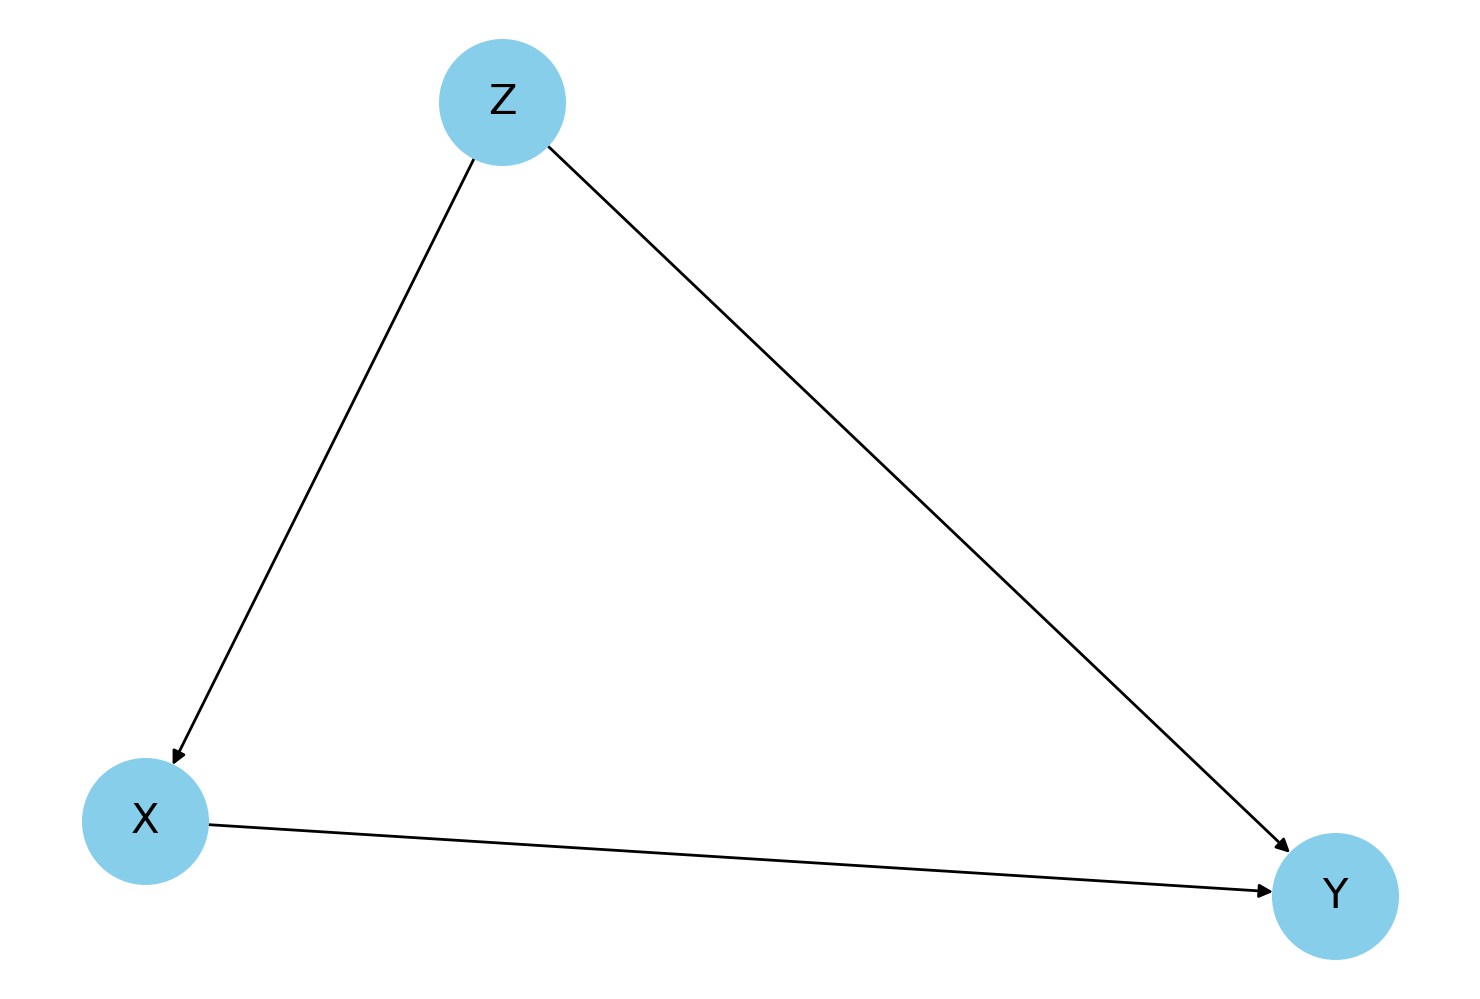

In [18]:
def create_dag(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    labels = {node: node for node in G.nodes()}
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=2000,
        node_color="skyblue",
        font_size=15,
        arrows=True,
    )
    plt.show()


# Scenario 1: Z soddisfa il criterio del backdoor
edges_scenario1 = [("Z", "X"), ("Z", "Y"), ("X", "Y")]
print("Scenario 1: Z blocca il percorso backdoor da X a Y")
create_dag(edges_scenario1)

Nel primo scenario è essenziale controllare la variabile $ Z $ per assicurare una stima accurata e non distorta dell'effetto causale di $ X $ su $ Y $. Questa necessità si basa su due aspetti chiave che rispecchiano il criterio del backdoor:

1. **Assenza di discendenza**: $ Z $ non è un discendente di $ X $, il che implica che $ Z $ non riceve alcun effetto da $ X $. Questo è cruciale perché, se $ Z $ fosse influenzato da $ X $, potrebbe generare ulteriori correlazioni indirette che alterano l'apparente effetto di $ X $ su $ Y $.

2. **Interruzione dei percorsi backdoor**: $ Z $ interrompe l'unico percorso backdoor tra $ X $ e $ Y $ che passa attraverso $ Z $ stesso. Regolando per $ Z $, si eliminano le influenze indirette di $ Z $ su $ Y $, isolando così l'effetto diretto di $ X $ su $ Y $.

Quindi, nel primo scenario, il controllo di $ Z $ è fondamentale per aderire correttamente al criterio del backdoor e per ottenere una stima affidabile dell'effetto di $ X $ su $ Y $.

Scenario 2: Z non blocca il percorso backdoor da X a Y perché Z è un discendente di X


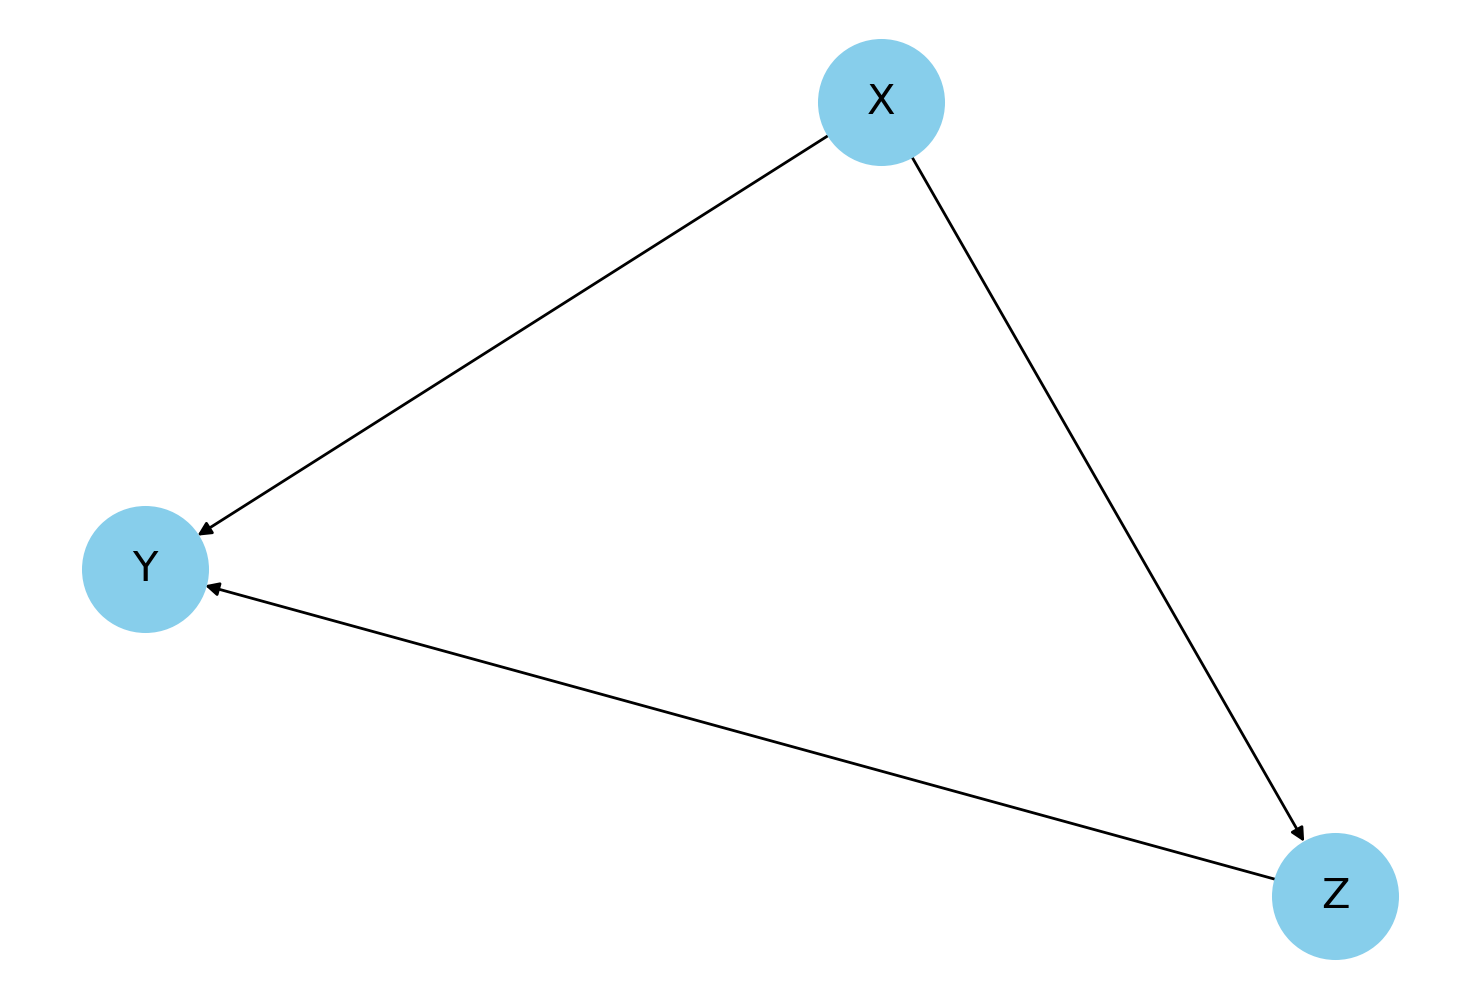

In [19]:
# Scenario 2: Z non soddisfa il criterio del backdoor
edges_scenario2 = [("X", "Z"), ("Z", "Y"), ("X", "Y")]
print(
    "Scenario 2: Z non blocca il percorso backdoor da X a Y perché Z è un discendente di X"
)
create_dag(edges_scenario2)

Nel secondo scenario, non è opportuno utilizzare $ Z $ per controllare l'effetto di $ X $ su $ Y $ poiché $ Z $ è un discendente di $ X $. Questa configurazione porta a problemi significativi:

- **Presenza di un discendente di $ X $ nel set di controllo**: Dato che $ Z $ riceve un influsso da $ X $, includere $ Z $ come variabile di controllo potrebbe aprire nuovi percorsi di confondimento tra $ X $ e $ Y $ attraverso variabili collaterali o collider. Questo significa che regolare per $ Z $ potrebbe introdurre un errore (bias) nella stima dell'effetto di $ X $ su $ Y $ anziché eliminarlo.

Pertanto, nel secondo scenario, includere $ Z $ nell'analisi causale non è appropriato e potrebbe addirittura peggiorare la precisione della stima degli effetti causali.

## Il Quartetto Causale

I dati forniti da {cite:t}`d2024causal` sono disponibili nel pacchetto R "quartets". È possibile effettuare l'importazione di tali dati nell'ambiente Python attraverso la seguente procedura. Tuttavia, è importante notare che è necessario aver precedentemente installato il modulo "rpy2".

In [20]:
import rpy2

print(rpy2.__version__)

ModuleNotFoundError: No module named 'rpy2'

In [33]:

from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri

utils = importr('utils')

# Specify your CRAN mirror
cran_mirror = 'https://cloud.r-project.org/'

# Install the package without being prompted for a mirror choice
utils.install_packages('quartets', repos=cran_mirror)

R[write to console]: apertura URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/quartets_0.1.1.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2253600 bytes (2.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to c


I pacchetti binari scaricati sono in
	/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T//Rtmpp9fHbk/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x31822ead0> [0]

## Collider

Il primo set di dati è denominato "causal_collider" e comprende le variabili "exposure," "outcome," e "covariate." Queste variabili sono state generatе seguendo la struttura causale di un collider, come descritto nel diagramma aciclico diretto (DAG) riportato di seguito.

In [34]:
# Ensure the conversion methods are set up
pandas2ri.activate()
quartets = importr('quartets')
causal_collider = data(quartets).fetch('causal_collider')['causal_collider']
# Convert the R data frame to a Pandas DataFrame
causal_collider_df = pandas2ri.rpy2py(causal_collider)
print(causal_collider_df.head())

   exposure   outcome  covariate
1  0.486219  1.705884   2.240050
2  0.065271  0.669207   0.924204
3 -1.402070 -1.596622  -0.999364
4 -0.546029 -1.733149  -2.343315
5 -0.401101  0.616867   0.207155


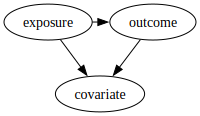

In [35]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("exposure")
    s.node("outcome")

f.node("covariate")
f.edge("exposure", "covariate", )
f.edge("outcome", "covariate")
f.edge("exposure", "outcome")

f

Se esaminiamo la relazione tra `exposure` e `outcome` notiamo una associazione positiva tra queste due variabili. Il coefficiente di regressione bivariato è 1 e corrisponde al vero effetto causale tra le due variabili. I dati, infatti, sono stati generati nel modo seguente: $Y = X + \varepsilon_y$.

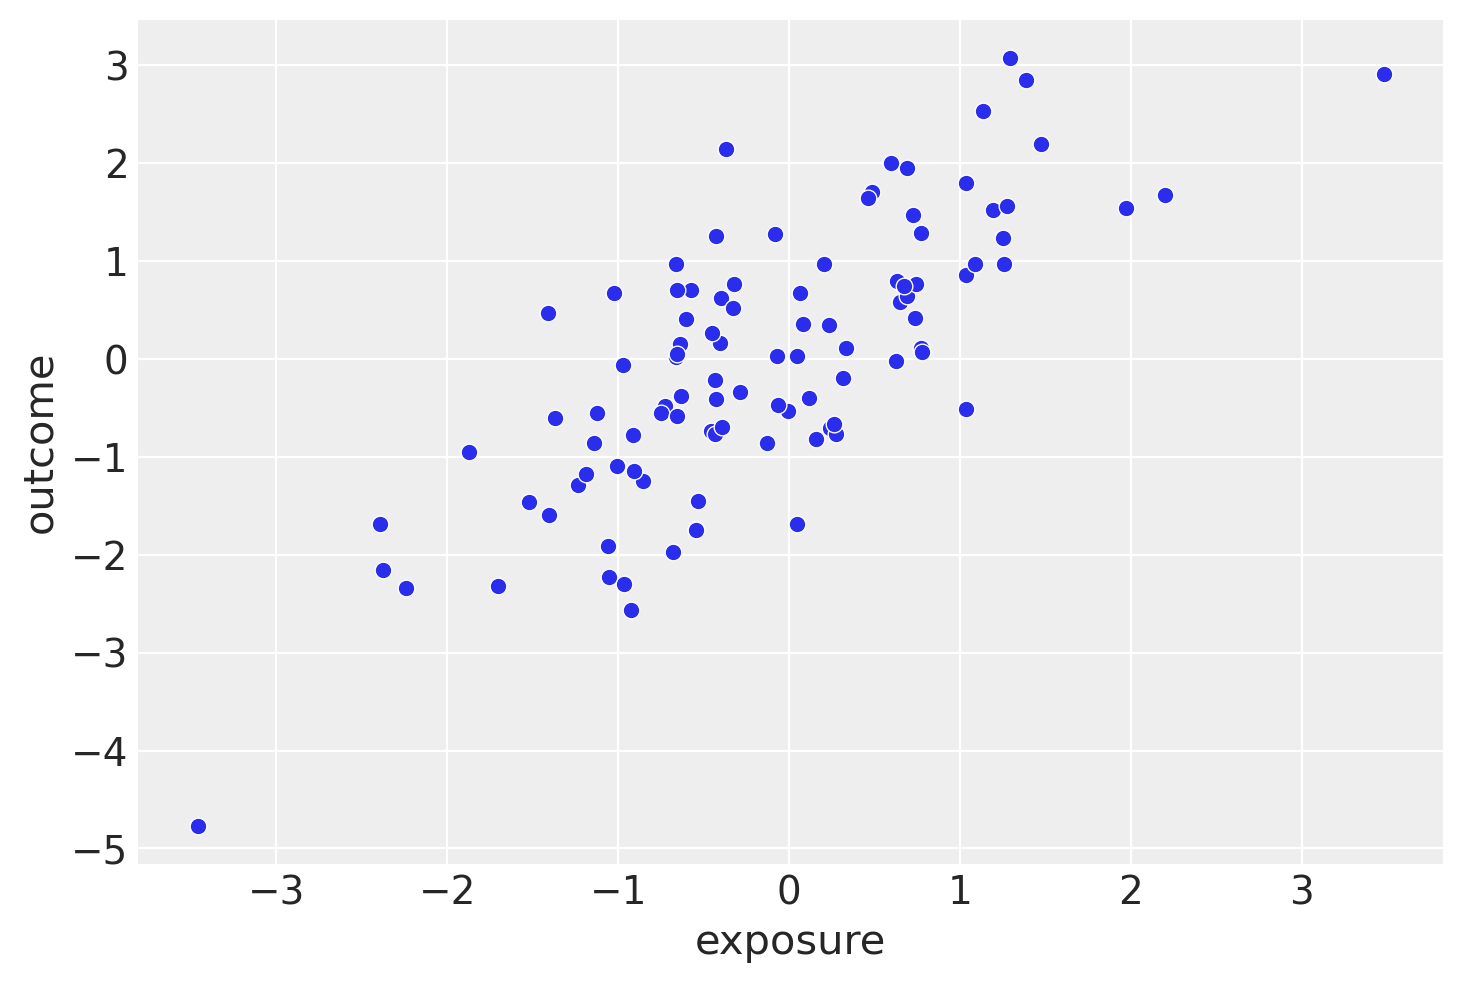

In [36]:
_ = sns.scatterplot(causal_collider_df, x="exposure", y="outcome")

In [37]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_collider_df['exposure'].corr(causal_collider_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.7686468291983661


La struttura causale descritta, dove $X \rightarrow Y$, $X \rightarrow Z$ e $Y \rightarrow Z$, rappresenta un tipico scenario di collider con $Z$ come variabile collider. In questo scenario, $Z$ è influenzato sia da $X$ che da $Y$. La questione centrale qui è capire come la scelta delle variabili nel modello di regressione influenzi la stima dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X`

Nel modello di regressione $Y \sim X$, stiamo stimando l'effetto di $X$ su $Y$ senza includere il collider $Z$ nel modello. Secondo il criterio del backdoor di Pearl, per ottenere una stima non distorta dell'effetto causale, dobbiamo chiudere i percorsi backdoor tra le variabili di causa ($X$) e effetto ($Y$) e non dobbiamo aprire nuovi percorsi che potrebbero introdurre delle correlazioni spurie.

Nella struttura data:

- Non ci sono variabili confondenti non controllate tra $X$ e $Y$ che richiedano aggiustamenti per soddisfare il criterio del backdoor.
- Includere $X$ come predittore di $Y$ in un modello di regressione chiude l'unico percorso diretto da $X$ a $Y$, senza la necessità di controllare altre variabili per ottenere una stima non distorta dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Nel modello di regressione $Y \sim X + Z$, includiamo il collider $Z$ come variabile nel modello insieme a $X$. Questo approccio introduce un problema: quando condizioniamo su un collider (cioè, includiamo il collider come variabile nel modello di regressione), apriamo un percorso non causale tra $X$ e $Y$ che era precedentemente chiuso. Questo può introdurre una correlazione spuria tra $X$ e $Y$ attraverso $Z$, portando a una stima distorta dell'effetto causale di $X$ su $Y$.

In termini del criterio del backdoor, condizionando su $Z$, si viola la condizione per una stima imparziale perché:

1. Si apre un percorso attraverso $Z$ (il collider), che non era un problema prima di condizionare su di esso.
2. Questo percorso aperto introduce una correlazione tra $X$ e $Y$ che non riflette l'effetto causale diretto di $X$ su $Y$, ma piuttosto l'effetto indiretto mediato da $Z$, che in questo caso non è desiderato per la stima dell'effetto causale diretto.

Eseguiamo l'analisi di regressione `outcome ~ exposure` per i dati nel set `causal_collider`. Poiché i dati nel set `causal_collider` sono generati in conformità con la struttura causale del collider,questa regressione produrrà una stima non distorta dell'effetto causale reale tra le due variabili.

In [38]:
mod8 = bmb.Model("outcome ~ exposure", causal_collider_df)
results8 = mod8.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [39]:
az.summary(results8, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.13,0.09,-0.04,0.31,0.0,0.0,3121.91,2335.68,1.0
exposure,1.00,0.09,0.84,1.17,0.0,0.0,3806.73,2550.29,1.0
outcome_sigma,0.89,0.06,0.76,1.01,0.0,0.0,3824.03,2931.08,1.0


Se invece aggiungiamo `covariate` nel modello di regressione come predittore di `outcome` otteniamo invece una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [40]:
mod8_bis = bmb.Model("outcome ~ exposure + covariate", causal_collider_df)
results8_bis = mod8_bis.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [41]:
az.summary(results8_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.12,0.08,-0.03,0.26,0.0,0.0,3851.63,2992.44,1.0
covariate,0.39,0.06,0.27,0.49,0.0,0.0,3185.71,2852.59,1.0
exposure,0.55,0.10,0.37,0.74,0.0,0.0,3310.22,2937.69,1.0
outcome_sigma,0.75,0.05,0.65,0.85,0.0,0.0,3957.42,3313.77,1.0


In sintesi, la corretta applicazione del criterio del backdoor in questa struttura causale suggerisce che per stimare l'effetto causale di $X$ su $Y$, dovremmo utilizzare il modello di regressione $Y \sim X$, e non $Y \sim X + Z$. Includere $Z$ nel modello introduce un bias nella stima dell'effetto causale di $X$ su $Y$ a causa dell'apertura di un percorso attraverso il collider $Z$, che non rappresenta l'effetto causale diretto che vogliamo stimare.

## Confounder

Il secondo data set è chiamato `causal_confounding`.

In [42]:
causal_confounding = data(quartets).fetch('causal_confounding')['causal_confounding']
# Convert the R data frame to a Pandas DataFrame
causal_confounding_df = pandas2ri.rpy2py(causal_confounding)
print(causal_confounding_df.head())

   covariate  exposure   outcome
1  -0.622268  0.033178 -0.429296
2   1.136951  0.362695  2.674816
3  -0.237867  0.242180 -0.647128
4   1.529001  1.463265  2.238149
5  -0.154499  0.779136  1.044306


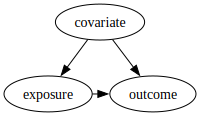

In [43]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("exposure")
    s.node("outcome")

f.node("covariate")
f.edge("covariate", "exposure")
f.edge("covariate", "outcome")
f.edge("exposure", "outcome")

f

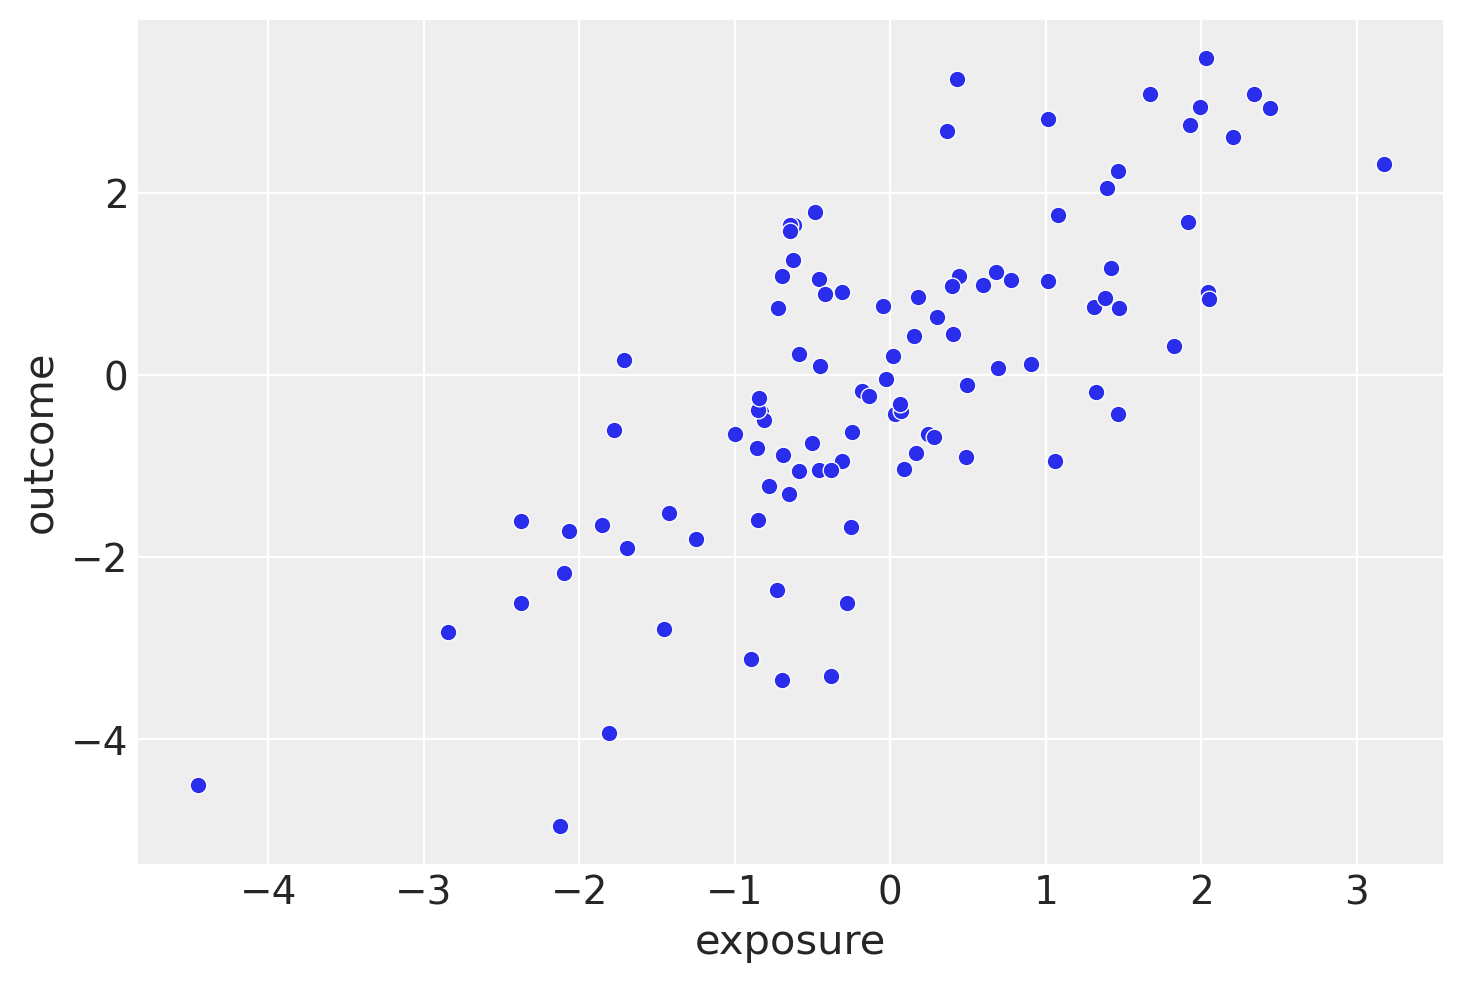

In [44]:
_ = sns.scatterplot(causal_confounding_df, x="exposure", y="outcome")

In [45]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_confounding_df['exposure'].corr(causal_confounding_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.7354068318349994


Quando i dati sono generati con una struttura di confounder, in cui $Z \rightarrow X$ e $Z \rightarrow Y$, oltre al percorso diretto $X \rightarrow Y$, ci troviamo in una configurazione classica in cui $Z$ funge da variabile confondente. Questo scenario è significativamente diverso dal caso del collider discusso precedentemente. Qui, $Z$ influisce sia sulla variabile indipendente ($X$) che sulla variabile dipendente ($Y$), creando un percorso backdoor che deve essere bloccato per ottenere una stima non distorta dell'effetto causale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Secondo il criterio del backdoor di Pearl, per ottenere una stima imparziale dell'effetto causale di $X$ su $Y$, dobbiamo controllare per (o aggiustare per) tutte le variabili confondenti che aprono percorsi backdoor tra $X$ e $Y$. In questo scenario, $Z$ è una variabile confondente perché influisce sia su $X$ che su $Y$, aprendo un percorso backdoor tra queste due variabili. 

Aggiustare per $Z$ (cioè, includere $Z$ nel modello di regressione $Y \sim X + Z$) blocca il percorso backdoor da $X$ a $Y$ attraverso $Z$, permettendoci di isolare l'effetto diretto di $X$ su $Y$. Facendo ciò, otteniamo una stima non distorta dell'effetto causale perché abbiamo eliminato l'influenza del confondente $Z$ sull'associazione tra $X$ e $Y$.

### Modello di regressione `Y ~ X`

Se utilizziamo il modello di regressione $Y \sim X$ senza includere il confondente $Z$, non stiamo bloccando il percorso backdoor aperto da $Z$. Ciò significa che qualsiasi associazione osservata tra $X$ e $Y$ potrebbe essere influenzata (confusa) dall'effetto di $Z$ su entrambe queste variabili, portando a una stima distorta dell'effetto causale di $X$ su $Y$. In altre parole, non possiamo essere sicuri che l'associazione osservata tra $X$ e $Y$ rifletta un effetto causale diretto di $X$ su $Y$, piuttosto che un'associazione indotta dal confondente comune $Z$.

Nel modello di regressione, se ignoriamo `covariate`, otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`. I dati sono stati generati con $Y = 0.5X + Z + \varepsilon_y$.

In [46]:
mod9 = bmb.Model("outcome ~ exposure", causal_confounding_df)
results9 = mod9.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [47]:
az.summary(results9, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.01,0.13,-0.25,0.22,0.0,0.0,3564.56,2389.82,1.0
exposure,1.00,0.09,0.84,1.18,0.0,0.0,3592.34,2663.58,1.0
outcome_sigma,1.21,0.09,1.06,1.38,0.0,0.0,3694.39,3032.86,1.0


Se invece condizioniamo su `covariate`, otteniamo una stima non distorta dell'effetto causale di `exposure` su `outcome`.

In [48]:
mod9_bis = bmb.Model("outcome ~ exposure + covariate", causal_confounding_df)
results9_bis = mod9_bis.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [49]:
az.summary(results9_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.04,0.10,-0.24,0.16,0.0,0.0,3570.53,2419.72,1.0
covariate,0.96,0.15,0.69,1.24,0.0,0.0,2787.20,2554.51,1.0
exposure,0.50,0.11,0.30,0.71,0.0,0.0,2680.87,2732.98,1.0
outcome_sigma,1.02,0.07,0.88,1.15,0.0,0.0,3724.17,2931.00,1.0


In sintesi, il criterio del backdoor ci dice che, nella presenza di variabili confondenti che aprono percorsi backdoor tra la variabile indipendente e la variabile dipendente, è essenziale controllare per queste variabili nel modello di regressione per ottenere una stima imparziale dell'effetto causale. Nel caso della struttura con $Z$ come confondente che influisce sia su $X$ che su $Y$, il modello $Y \sim X + Z$ fornisce una stima corretta dell'effetto causale di $X$ su $Y$ perché blocca il percorso backdoor attraverso $Z$, mentre il modello $Y \sim X$ non lo fa, lasciando la stima dell'effetto causale potenzialmente distorta.

## Mediazione

Il terzo set di dati si chiama `causal_mediator`.

In [50]:
causal_mediator = data(quartets).fetch('causal_mediator')['causal_mediator']
# Convert the R data frame to a Pandas DataFrame
causal_mediator_df = pandas2ri.rpy2py(causal_mediator)
print(causal_mediator_df.head())

   exposure  covariate   outcome
1  0.067197   0.129825 -0.140413
2  0.087756   0.002409 -0.031944
3 -0.751281   0.383943  0.632418
4  0.076000  -0.376841 -0.910737
5 -1.569622  -1.661511 -2.834616


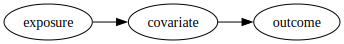

In [51]:
f = graphviz.Digraph()

# Definizione dei nodi e degli archi
f.edge("exposure", "covariate")
f.edge("covariate", "outcome")

# Impostazione dell'orientamento orizzontale
f.attr(rankdir='LR')
f

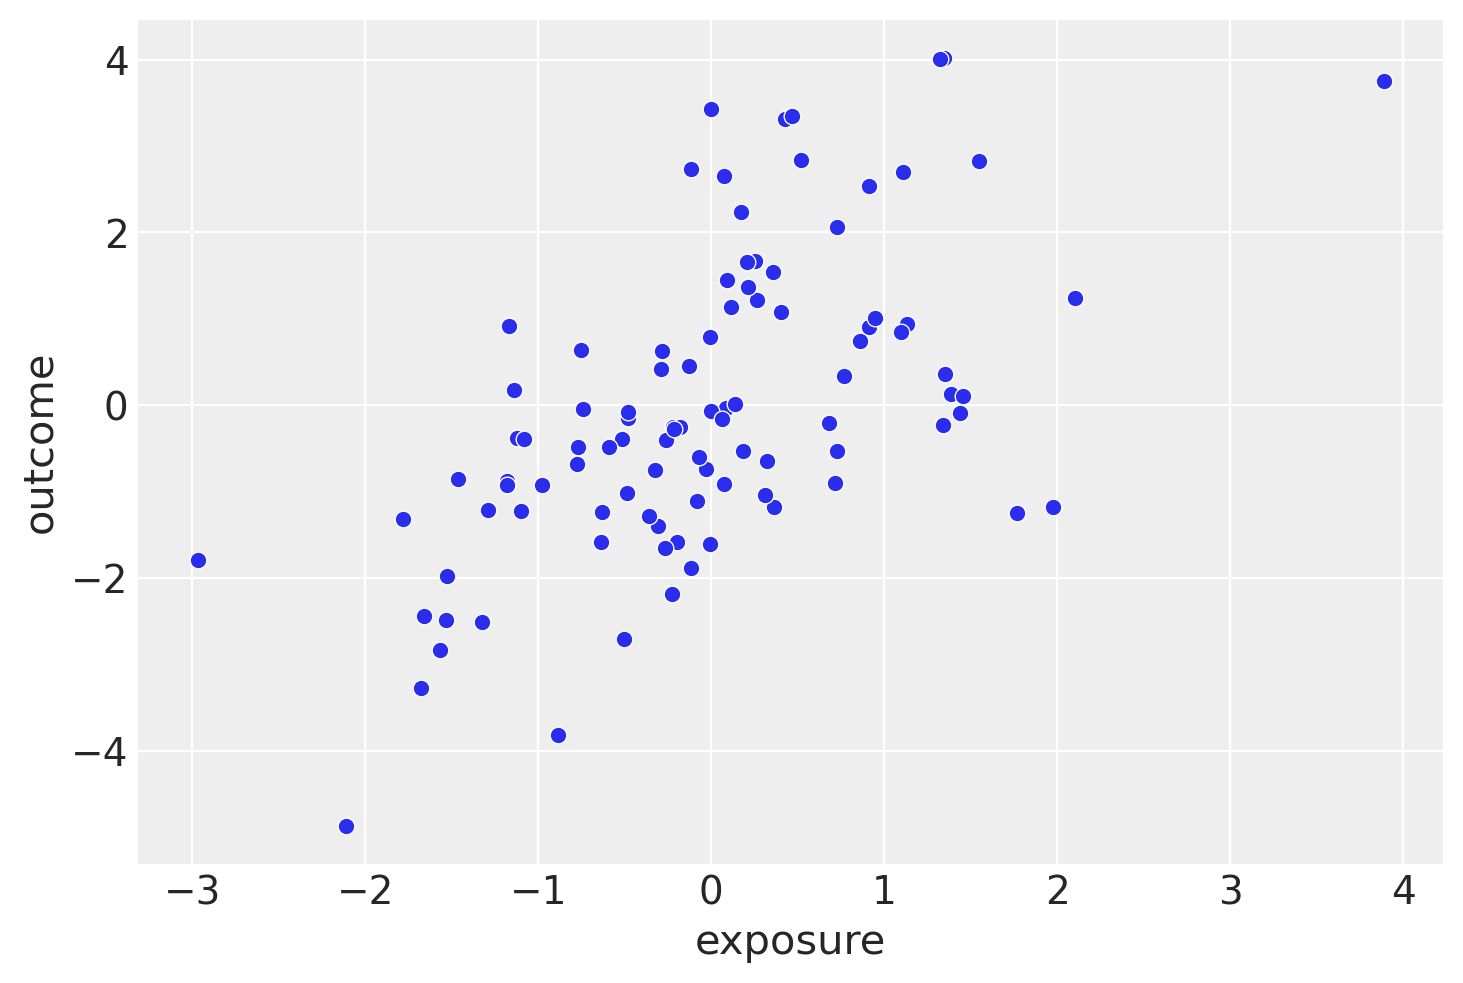

In [52]:
_ = sns.scatterplot(causal_mediator_df, x="exposure", y="outcome")

In [53]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_mediator_df['exposure'].corr(causal_mediator_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.5944519516171226


Nella struttura di mediazione, $X \rightarrow Z \rightarrow Y$, $Z$ agisce come variabile mediatrice nel percorso causale da $X$ a $Y$. Questo significa che l'effetto di $X$ su $Y$ passa attraverso $Z$. L'obiettivo della modellazione causale in questo scenario è spesso di stimare l'effetto totale di $X$ su $Y$, che include sia l'effetto diretto di $X$ su $Y$ (se presente) sia l'effetto indiretto mediato da $Z$.

### Modello di regressione `Y ~ X`

Nel modello di regressione $Y \sim X$, stiamo cercando di stimare l'effetto totale di $X$ su $Y$, senza cercare di decomporre questo effetto in componenti diretti e indiretti. In questa configurazione, non dobbiamo aggiustare per la variabile mediatrice $Z$ quando il nostro obiettivo è stimare l'effetto totale, perché fare ciò rimuoverebbe l'effetto indiretto di $X$ su $Y$ attraverso $Z$ dalla nostra stima, lasciandoci solo con l'effetto diretto (se esiste).

Secondo il criterio del backdoor di Pearl, non ci sono percorsi backdoor tra $X$ e $Y$ che richiedono di essere bloccati, poiché l'unico percorso da $X$ a $Y$ è attraverso $Z$, che è il percorso causale di interesse. Pertanto, il modello $Y \sim X$ non apre nuovi percorsi backdoor e ci fornisce una stima corretta dell'effetto totale di $X$ su $Y$.

### Modello di regressione `Y ~ X + Z`

Nel modello di regressione $Y \sim X + Z$, stiamo cercando di controllare per $Z$ oltre a includere $X$. Mentre questo modello può essere utile per esplorare l'effetto diretto di $X$ su $Y$ controllando per l'effetto mediatore di $Z$, questo approccio non è appropriato quando l'obiettivo è stimare l'effetto totale di $X$ su $Y$. Aggiustando per $Z$, rimuoviamo l'effetto della mediazione di $Z$ dall'effetto totale di $X$ su $Y$, il che potrebbe portarci a sottostimare l'effetto totale di $X$ su $Y$ poiché escludiamo l'effetto indiretto attraverso $Z$.

Inoltre, secondo il criterio del backdoor, aggiustare per la variabile mediatrice in un percorso causale diretto (come $X \rightarrow Z \rightarrow Y$) non è necessario per ottenere una stima imparziale dell'effetto totale di $X$ su $Y$, e può effettivamente introdurre bias se il nostro obiettivo è di stimare l'effetto totale piuttosto che isolare l'effetto diretto.

Adattando ai dati un modello di regressione bivariato otteniamo una stima non distorta del vero effetto causale di `exposure` su `outcome`. Infatti, i dati sono stati generati con $Y = Z + \varepsilon_y$.

In [54]:
mod10 = bmb.Model("outcome ~ exposure", causal_mediator_df)
results10 = mod10.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [55]:
az.summary(results10, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.00,0.14,-0.28,0.25,0.0,0.0,3665.35,2997.87,1.0
exposure,0.99,0.14,0.72,1.26,0.0,0.0,3726.98,2621.86,1.0
outcome_sigma,1.40,0.10,1.22,1.60,0.0,0.0,3703.01,2950.67,1.0


Se invece condizioniamo sul mediatore (`covariate`) otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [56]:
mod10_bis = bmb.Model("outcome ~ exposure + covariate", causal_mediator_df)
results10_bis = mod10_bis.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [57]:
az.summary(results10_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.01,0.09,-0.15,0.19,0.0,0.0,3719.62,2670.24,1.0
covariate,1.07,0.09,0.89,1.24,0.0,0.0,2479.69,2612.85,1.0
exposure,0.00,0.13,-0.24,0.24,0.0,0.0,2651.49,2556.06,1.0
outcome_sigma,0.92,0.07,0.80,1.05,0.0,0.0,3570.91,2453.08,1.0


In sintesi, per stimare correttamente l'effetto totale di $X$ su $Y$ in una struttura di mediazione, è necessario utilizzare il modello di regressione $Y \sim X$, che ci fornisce una stima dell'effetto totale includendo sia gli effetti diretti che quelli indiretti mediati da $Z$. Il modello $Y \sim X + Z$ è appropriato solo se siamo interessati a isolare l'effetto diretto di $X$ su $Y$, controllando per l'effetto di $Z$, ma non per stimare l'effetto totale di $X$ su $Y$.


Nel modello di mediazione $ X \rightarrow Z \rightarrow Y $, dove $ X $ è la variabile indipendente, $ Z $ è la variabile mediatrice, e $ Y $ è la variabile dipendente, l'applicazione del criterio backdoor di Judea Pearl può essere illustrata considerando come stimare l'effetto totale di $ X $ su $ Y $ e come separare questo effetto in componenti diretto e indiretto.

### Obiettivo dell'analisi
Nel modello di mediazione, l'obiettivo può essere duplice:
1. **Stimare l'effetto totale di $ X $ su $ Y $**: Questo include sia l'effetto diretto di $ X $ su $ Y $ che non passa attraverso $ Z $, sia l'effetto indiretto che passa attraverso $ Z $.
2. **Separare l'effetto totale in effetti diretti e indiretti**: Questo ci aiuta a comprendere quanto dell'effetto di $ X $ su $ Y $ è mediato da $ Z $.

### Applicazione del Criterio Backdoor
Nel caso specifico del modello di mediazione:
- **Per stimare l'effetto totale di $ X $ su $ Y $**: Non dovresti controllare per $ Z $ quando stai stimando l'effetto totale di $ X $ su $ Y $. In questo caso, il criterio backdoor non richiede di bloccare alcun percorso perché non ci sono variabili confounding non osservate tra $ X $ e $ Y $ che siano correlate sia con $ X $ sia con $ Y $ attraverso percorsi non causali.
- **Per stimare l'effetto diretto di $ X $ su $ Y $**: Dovresti controllare per $ Z $ per eliminare l'effetto del mediatore e isolare l'effetto diretto di $ X $ su $ Y $.

### Considerazioni Pratiche
1. **Analisi di mediazione**: Tipicamente si esegue un'analisi di regressione multipla dove si include $ Z $ come predittore insieme a $ X $ per valutare gli effetti diretti e indiretti.
   - **Modello 1**: Regressione di $ Z $ su $ X $ per stimare l'effetto di $ X $ su $ Z $ (path a).
   - **Modello 2**: Regressione di $ Y $ su $ X $ e $ Z $ per stimare l'effetto diretto di $ X $ su $ Y $ controllando per $ Z $ e per valutare l'effetto di $ Z $ su $ Y $ (path b).

2. **Interpretazione**: 
   - **Effetto diretto**: L'effetto di $ X $ su $ Y $ che non passa per $ Z $ (coefficiente di $ X $ in Modello 2).
   - **Effetto indiretto**: Calcolato come il prodotto dei coefficienti dei percorsi da $ X $ a $ Z $ e da $ Z $ a $ Y $ (cioè, il prodotto dei coefficienti di path a e path b).

In sintesi, nel modello di mediazione $ X \rightarrow Z \rightarrow Y $, il criterio backdoor ci aiuta a decidere quando includere o escludere il mediatore $ Z $ nelle regressioni per isolare gli effetti diretti e indiretti di $ X $ su $ Y $. Questa è una componente fondamentale per l'interpretazione corretta dei meccanismi sottostanti alle relazioni causali osservate.

## Causal M-bias

Nell'ultimo set di dati ci sono due fattori aggiuntivi, U1 e U2. Entrambi causano Z, U1 causa `exposure`, X, e U2 causa `outcome`, Y. Effettuare un aggiustamento per Z durante la stima dell'effetto di X su Y produce un risultato distorto.

In [58]:
causal_m_bias = data(quartets).fetch('causal_m_bias')['causal_m_bias']
# Convert the R data frame to a Pandas DataFrame
causal_m_bias_df = pandas2ri.rpy2py(causal_m_bias)
print(causal_m_bias_df.head())

         u1        u2  covariate  exposure   outcome
1  0.544050 -1.354656   5.236805  2.451155 -0.142505
2  0.085600  0.131291  -0.047646  0.976479  0.711355
3  0.674619 -0.461275   6.377459  0.282988 -0.198427
4  1.896146  0.580910  15.866842  1.961346  4.188398
5  0.350692 -1.709183   0.796247  0.854928 -1.845741


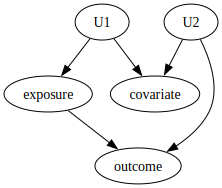

In [59]:
f = graphviz.Digraph()
f.edge("U1", "covariate")
f.edge("U1", "exposure")
f.edge("U2", "covariate")
f.edge("U2", "outcome")
f.edge("exposure", "outcome")

f

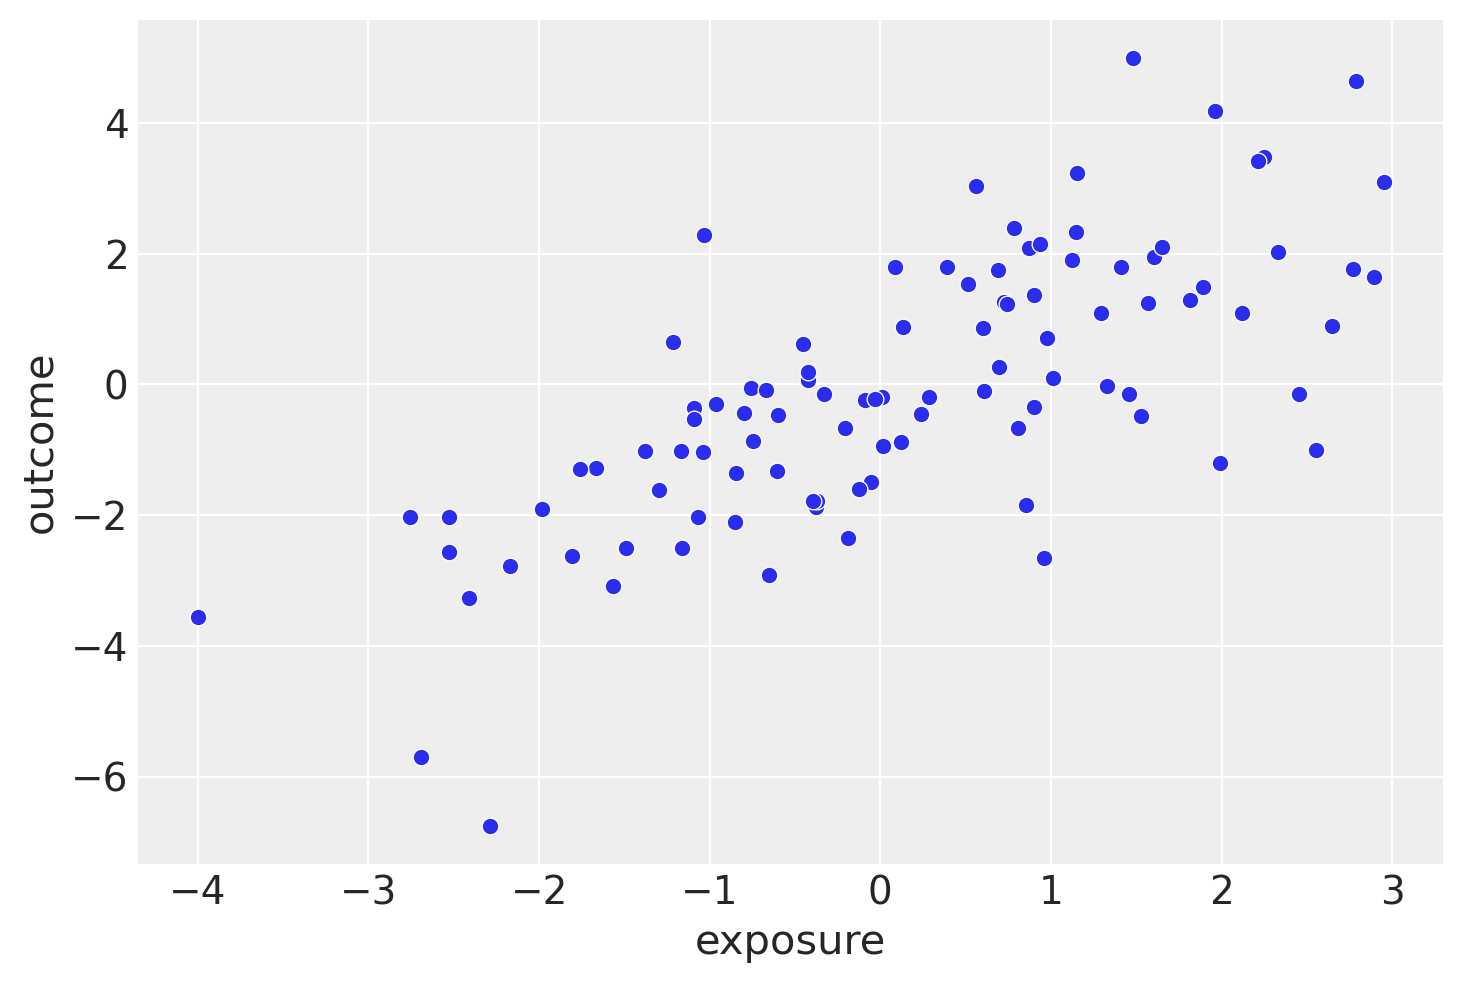

In [60]:
_ = sns.scatterplot(causal_m_bias_df, x="exposure", y="outcome")

In [61]:
# Calculate the Pearson correlation between 'exposure' and 'outcome'
correlation = causal_m_bias_df['exposure'].corr(causal_m_bias_df['outcome'])
print("Correlation between 'exposure' and 'outcome':", correlation)

Correlation between 'exposure' and 'outcome': 0.7241883907049459


La struttura causale nota come struttura di M-bias (o a volte chiamata struttura a collider aperto) è caratterizzata da due variabili non osservate ($U1$ e $U2$) che influenzano sia la covariata che l'esposizione o l'esito, rispettivamente, oltre al percorso diretto da esposizione a esito. In questo scenario, la covariata è collegata sia all'esposizione che all'esito attraverso le variabili non osservate, formando una struttura a "M".

### Modello di regressione `Y ~ X`

Quando stimiamo l'effetto causale dell'esposizione sull'esito con il modello $outcome \sim exposure$, non includiamo la covariata nel modello. In questo caso, stiamo effettivamente ignorando la struttura a "M" e stimando direttamente l'effetto dell'esposizione sull'esito. Poiché il criterio del backdoor ci dice di bloccare i percorsi backdoor per ottenere una stima non distorta dell'effetto causale e non ci sono percorsi backdoor aperti tra esposizione ed esito che passano attraverso le variabili osservate, questo modello fornisce una stima corretta dell'effetto causale di esposizione su esito, assumendo che non ci siano altre variabili confondenti non controllate.

### Modello di regressione `Y ~ X + Z`

Tuttavia, quando aggiungiamo la covariata al modello ($outcome \sim exposure + covariate$), introduciamo potenzialmente un bias nella nostra stima dell'effetto causale. Questo accade perché condizionando sulla covariata, che è al centro della struttura a "M", apriamo un percorso non causale tra esposizione ed esito attraverso le variabili non osservate ($U1$ e $U2$). In altre parole, includere la covariata nel modello crea una correlazione spuria tra esposizione ed esito attraverso le variabili latenti che influenzano sia la covariata che l'esposizione o l'esito. 

In un contesto di M-bias, condizionare sulla covariata "apre" il collider (la covariata stessa), che non era un problema quando la covariata non era inclusa nel modello. Questo rende il modello $outcome \sim exposure + covariate$ inadatto per la stima corretta dell'effetto causale di esposizione su esito in questa specifica struttura causale.

Nel caso di questa struttura casusale, il vero effetto causale di `exposure` su `outcome` è $\beta$ = 1. Se ignoriamo `covariate` nel modello di regressione otteniamo una stima non distorta del vero effetto causale.

In [62]:
mod11 = bmb.Model("outcome ~ exposure", causal_m_bias_df)
results11 = mod11.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [63]:
az.summary(results11, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.22,0.15,-0.48,0.07,0.0,0.0,4097.99,2579.64,1.0
exposure,1.00,0.10,0.82,1.19,0.0,0.0,4169.96,3087.78,1.0
outcome_sigma,1.44,0.10,1.25,1.63,0.0,0.0,4213.60,3197.64,1.0


Se invece usiamo `covariate` come predittore nel modello di regressione otteniamo una stima distorta dell'effetto causale di `exposure` su `outcome`.

In [64]:
mod11_bis = bmb.Model("outcome ~ exposure + covariate", causal_m_bias_df)
results11_bis = mod11_bis.fit(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [65]:
az.summary(results11_bis, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.22,0.15,-0.48,0.06,0.0,0.0,3911.91,2567.89,1.0
covariate,0.04,0.03,-0.01,0.09,0.0,0.0,2463.49,2677.93,1.0
exposure,0.88,0.13,0.64,1.13,0.0,0.0,2751.16,2691.96,1.0
outcome_sigma,1.44,0.11,1.25,1.64,0.0,0.0,3315.05,2579.48,1.0


In sintesi, in una struttura causale di M-bias, il modello di regressione $outcome \sim exposure$ senza includere la covariata è preferibile per stimare l'effetto causale dell'esposizione sull'esito, perché evita di introdurre il collider bias che si verificherebbe includendo la covariata nel modello. Questo esempio dimostra l'importanza di considerare attentamente la struttura causale sottostante e il criterio del backdoor quando si sceglie quali variabili includere nei modelli di regressione per la stima degli effetti causali.

## Riflessioni conclusive

In conclusione, esaminando quattro distinti set di dati, riscontriamo che, se non consideriamo le `covariate`, otteniamo consistentemente una stima dell'"effetto medio del trattamento" (ATE) pari a 1. Tuttavia, questo valore di 1 rappresenta una stima corretta dell'effetto causale solo nelle strutture causali del collider e dell'M-bias. In questi casi, non includendo le `covariate`, si ottiene effettvamente una stima non distorta dell'effetto causale dell'`esposizione` sull'`esito`.

Al contrario, se includiamo le `covariate` nell'analisi, osserviamo che le stime dell'ATE risultano distorte: 0.55 nel caso della struttura causale del collider e 0.88 nel caso dell'M-bias.

Quando i dati sono generati da una struttura causale che include un confounder, l'effetto causale corretto è 0.5. Ignorare le `covariate` in questo scenario porta a una stima distorta di 1. Includendole, invece, otteniamo una stima accurata dell'effetto causale reale.

Nel contesto della struttura causale della mediazione, l'effetto totale dell'`esposizione` sull'`esito` è 1, ma l'effetto diretto è 0. Non considerando le `covariate`, la stima dell'effetto totale risulta accurata. Tuttavia, includendo le `covariate`, si ottiene una stima distorta dell'effetto totale, pari a 0.

Queste osservazioni dimostrano che l'inferenza causale non può essere affrontata semplicemente applicando meccanicamente il modello statistico della regressione lineare. Senza ulteriori conoscenze, che non possono essere derivate esclusivamente dai dati osservati, non è possibile ottenere stime non distorte degli effetti causali. Come suggerito dal titolo dell'articolo, l'inferenza causale va oltre le tecniche statistiche: essa richiede informazioni supplementari sulle caratteristiche del fenomeno studiato.

Per trarre conclusioni corrette sui meccanismi causali, è essenziale disporre di informazioni dettagliate sul processo generativo dei dati. Benché spesso queste informazioni non siano direttamente disponibili, i ricercatori possono adottare strategie per minimizzare il rischio di errori interpretativi. Un passo fondamentale consiste nell'identificare ipotetici meccanismi causali prima di procedere con le stime degli effetti, utilizzando diagrammi causali come i grafici aciclici diretti per mappare le relazioni tra le variabili. Questo processo aiuta a determinare quali fattori includere nell'analisi, seguendo il "backdoor criterion" proposto da Judea Pearl, per chiudere i percorsi indiretti tra esposizione ed esito che potrebbero introdurre confondimenti.

In assenza di una comprensione del fenomeno in esame, è cruciale che i ricercatori prestino attenzione all'ordine temporale dei fattori. Questo approccio, fondamentale per l'inferenza causale, implica che l'esposizione avvenga prima dell'esito per stabilire una relazione causale plausibile. Inoltre, è importante che tutte le covariate considerate nell'analisi precedano temporalmente l'esposizione per evitare potenziali bias di specificazione, specialmente nei contesti di collider e mediazione. Seguendo questi principi, i ricercatori possono ridurre il rischio di stime errate degli effetti causali.

## Esercizio

Utilizzare i concetti presentati in questo capitolo per analizzare l'articolo selezionato nel contesto del progetto di gruppo.

## Informazioni sull'Ambiente di Sviluppo

In [66]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun May 12 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.22.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

bambi      : 0.13.0
rpy2       : 3.5.16
graphviz   : 0.20.3
arviz      : 0.18.0
statsmodels: 0.14.1
seaborn    : 0.13.2
pymc       : 5.14.0
pandas     : 2.2.2
networkx   : 3.3
matplotlib : 3.8.4
numpy      : 1.26.4
scipy      : 1.13.0

Watermark: 2.4.3

